# Подготовка прототипа модели для металлообрабатывающего предприятия

**Задача:**  
Подготовить прототип модели машинного обучения для «Цифры».

Компания разрабатывает решения для эффективной работы промышленных предприятий.  
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.   
В вашем распоряжении данные с параметрами добычи и очистки.  
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.  



## Описание данных
#### Технологический процесс
Rougher feed — исходное сырье;  
Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant;  
Xanthate ** — ксантогенат (промотер, или активатор флотации);  
Sulphate — сульфат (на данном производстве сульфид натрия);  
Depressant — депрессант (силикат натрия).  

#### Rougher process (англ. «грубый процесс») — флотация
Rougher tails — отвальные хвосты;  
Float banks — флотационная установка;  
Cleaner process — очистка;  
Rougher Au — черновой концентрат золота;  
Final Au — финальный концентрат золота;  
#### Параметры этапов
air amount — объём воздуха;  
fluid levels — уровень жидкости;  
feed size — размер гранул сырья;  
feed rate — скорость подачи;  

### Наименование признаков
Наименование признаков должно быть такое:  
    [этап].[тип_параметра].[название_параметра]  

Возможные значения для блока [этап]:  
rougher — флотация  
primary_cleaner — первичная очистка  
secondary_cleaner — вторичная очистка  
final — финальные характеристики  

Возможные значения для блока [тип_параметра]:  
input — параметры сырья  
output — параметры продукта  
state — параметры, характеризующие текущее состояние этапа  
calculation — расчётные характеристики   


#### Часть 1. [Подготовка данных.](#part1)
* [1. Импорт библиотек](#part1.1)
* [2. Изучение файлов, получение общей информации](#part1.2)
* [3. Вычисление эффективности обогащения](#part1.3)
* [4. Предобработка данных](#part1.4)

#### Часть 2. [Анализ данных](#part2)
* [1. Изменение концентрации металлов на разных этапах очистки](#part2.1)
* [2. Сравнение размеров частиц в тренировочной и тестовой выборках](#part2.2)
* [3. Изменение суммарной концентрации всех веществ на разных стадиях](#part2.3)
* [4. Предобработка данных](#part1.4)
#### Часть 3. [Модель](#part3)
* [1. Функция для подсчета итогового SMAPE](#part3.1)
* [3. Разбиение данных](#part3.2)
* [3. Решающее дерево](#part3.3)
* [4. Случайный лес](#part3.4)
* [5. Линейная регрессия](#part3.5)
* [6. Проверка на тестовой выборке](#part3.6)
#### [Общий вывод](#part4)
#### [Чек-лист](#part5)

<a id='part1'></a>
# 1. Подготовка данных
<a id='part1.1'></a>
## 1.1 Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import variance
from scipy import stats as st
from sklearn.metrics import mean_absolute_error, make_scorer
from scipy.stats import mstats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor

<a id='part1.2'></a>
## 1.2 Изучение файлов, получение общей информации

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

В данных есть пропуски.  
В тестовой выборке отсутствуют признаки расчетных характеристик (calculation) и параметры продуктов (otput).

<a id='part1.3'></a>
## 1.3 Вычисление эффективности обогащения

In [5]:
# выделяем отдельный фрейм и убираем пропуски
train_for_test = train[['rougher.output.concentrate_au','rougher.input.feed_au',
                        'rougher.output.tail_au','rougher.output.recovery']].dropna()

def calc_recovery(row):
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    if f != 0 and (c-t) !=0:
        return c*(f-t)/f/(c-t)*100
train_for_test['recovery_calced']=train.apply(calc_recovery, axis=1)
print('MAE:', mean_absolute_error(train_for_test['recovery_calced'],train_for_test['rougher.output.recovery']))

MAE: 1.0512313043960013e-14


## Вывод 
Эффективность обогащения, рассчитанная вручную, практически равна значению из признака. МАЕ = 1.05*10<sup>-14</sup>.  
Данные можно считать корректными.

<a id='part1.4'></a>
## 1.4 Предобработка данных
В тестовой выборке отсутствуют некоторые признаки. Добавим их из полного датасета.

In [6]:
test = test.set_index('date')
full = full.set_index('date')
for col in list(set(full.columns) - set(test.columns)):
    test = test.join(full[col].loc[test.index])
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

Известно, что соседние по времени параметры похожи. Это значит, что пропуски можно заполнить методом ffill.

In [7]:
train = train.fillna(method='ffill')
test = test.fillna(method='ffill')

Исследуем данные

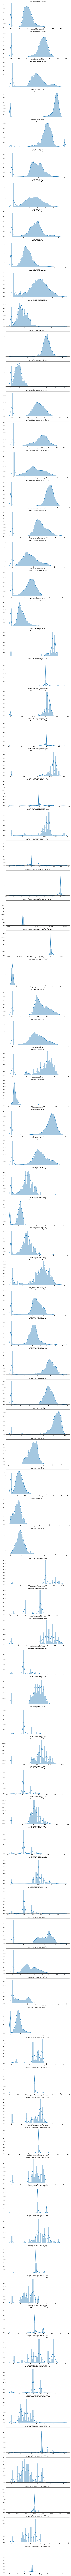

In [8]:
fig, axes = plt.subplots(86,figsize=(12,500))
j=0
for i, col in enumerate(train.columns):

    if col != 'date':
        sns.distplot(train[col],ax=axes[j]).set_title(col)
        j+=1

Во всех столбцах присутствуют выбросы при значении 0. Выбросы помешают корректному обучени модели, поэтому их стоит удалить.

In [9]:
for col in train.columns:
    train = train[(train[col] != 0)]
for col in test.columns:
    test=test[(test[col] != 0)]
print(train.shape)
print(test.shape)

(13224, 87)
(5026, 86)


## Вывод 
В тестовую выборку добавлены целевые признаки.  
В тренировочной и тестовой выборках пропуски заполнены методо *ffill* и удалены выбросы при значении 0.
Из тренировочной выборки было удалено 3600 строк, из тестовой - 800.

<a id='part2'></a>
# 2. Анализ данных
<a id='part2.1'></a>
## 2.1 Изменение концентрации металлов на разных этапах очистки

Медианы концентраций на различных этапах:
variable
rougher.output.concentrate_ag            11.791843
primary_cleaner.output.concentrate_ag     8.279725
final.output.concentrate_ag               5.015952
Name: value, dtype: float64
Медианы концентраций на различных этапах:
variable
rougher.output.concentrate_pb             7.751283
primary_cleaner.output.concentrate_pb     9.903659
final.output.concentrate_pb              10.308258
Name: value, dtype: float64
Медианы концентраций на различных этапах:
variable
rougher.output.concentrate_au            20.020177
primary_cleaner.output.concentrate_au    33.132402
final.output.concentrate_au              44.814751
Name: value, dtype: float64


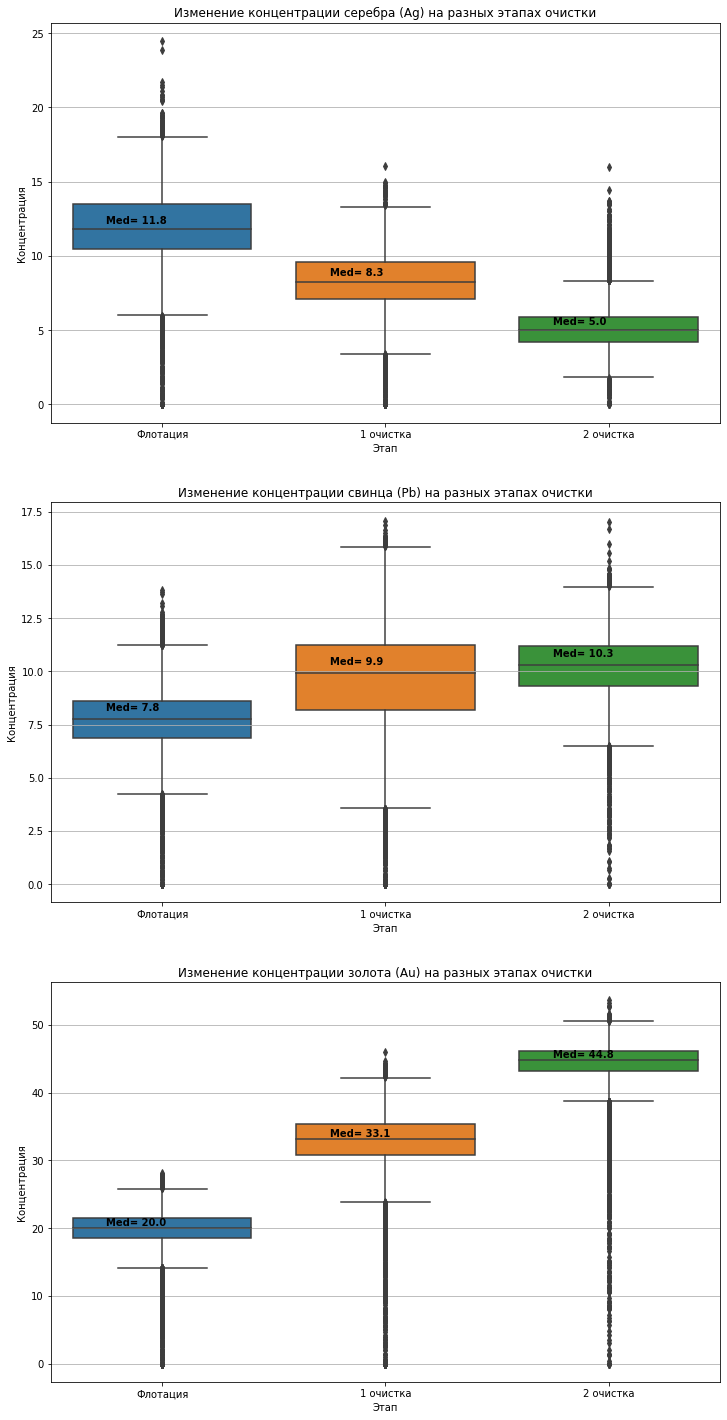

In [10]:
data = []
for me in ['ag','pb','au']:
    x = [train['rougher.output.concentrate_'+me],train['primary_cleaner.output.concentrate_'+me],
        train['final.output.concentrate_'+me]]
    data.append(x)
    
fig, ax = plt.subplots(3, figsize=(12, 25))

for i in range(0,3):
  
    data[i]=pd.concat(data[i],axis=1)
    data[i]=data[i].reset_index().melt(id_vars=['index'])
   
    if i==0:
        me_name = 'серебра (Ag)'
    if i==1:
        me_name = 'свинца (Pb)'
    if i==2:
        me_name = 'золота (Au)'
    
    median = data[i].groupby(['variable'])['value'].median()
    median=median.iloc[::-1]
    print('Медианы концентраций на различных этапах:')
    print(median)
    vertical_offset = 3
       
    sns.boxplot(x = 'variable', y='value', data = data[i], ax=ax[i]) \
    .set_title('Изменение концентрации '+me_name+' на разных этапах очистки')
    
    for xtick in ax[i].get_xticks():
        
        ax[i].text(xtick-0.25, median[xtick]+0.4 , 'Med= {:.1f}'.format(median[xtick]),
            weight='semibold')
    
    xticksnames=['Флотация','1 очистка','2 очистка']
    ax[i].set_xticklabels(xticksnames)
    ax[i].yaxis.grid(True)
    ax[i].set(xlabel='Этап', ylabel='Концентрация')    

## Вывод
С каждым этапом очистки падает концентрация серебра, немного возрастает концентрация свинца и сильно растет концентрация золота.

<a id='part2.2'></a>
## 2.2 Сравнение размеров частиц в тренировочной и тестовой выборках.

Text(0.5, 1.0, 'Размеры частиц после флотации')

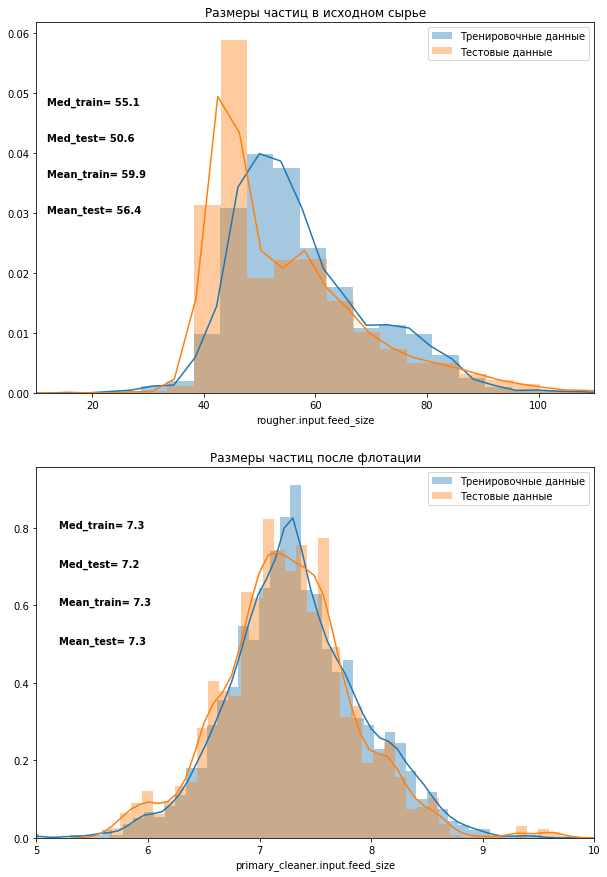

In [11]:
data_train = [train['rougher.input.feed_size'],train['primary_cleaner.input.feed_size']]
data_test = [test['rougher.input.feed_size'],test['primary_cleaner.input.feed_size']]

fig, ax = plt.subplots(2, figsize=(10, 15))
for i in range(0,2):
    
    sns.distplot(data_train[i],bins=100, kde=True, ax=ax[i])
    sns.distplot(data_test[i],bins=100, kde=True, ax=ax[i])
    ax[i].legend(['Тренировочные данные', 'Тестовые данные'])
    
    median_train = data_train[i].median()
    median_test = data_test[i].median()
    mean_train = data_train[i].mean()
    mean_test = data_test[i].mean()
    #median=median.iloc[::-1]
    if i == 0:
        y=0.03
        x=12
    if i == 1:
        y=0.5
        x=5.2
        #set=
    ax[i].text(x, y+y/5*3 , 'Med_train= {:.1f}'.format(median_train),
            weight='semibold')
    ax[i].text(x, y+y/5*2 , 'Med_test= {:.1f}'.format(median_test),
            weight='semibold')
    ax[i].text(x, y+y/5 , 'Mean_train= {:.1f}'.format(mean_train),
            weight='semibold')
    ax[i].text(x, y , 'Mean_test= {:.1f}'.format(mean_test),
            weight='semibold')
    
ax[0].set_xlim([10, 110])
ax[1].set_xlim([5, 10])
ax[0].set_title('Размеры частиц в исходном сырье')
ax[1].set_title('Размеры частиц после флотации')

## Вывод
В тестовой выборке в исходном сырье размеры частиц немного меньше, чем в тренировочной выборке.  
После флотации размеры частици практически одинаковые.

<a id='part2.3'></a>
## 2.3 Изменение суммарной концентрации всех веществ на разных стадиях

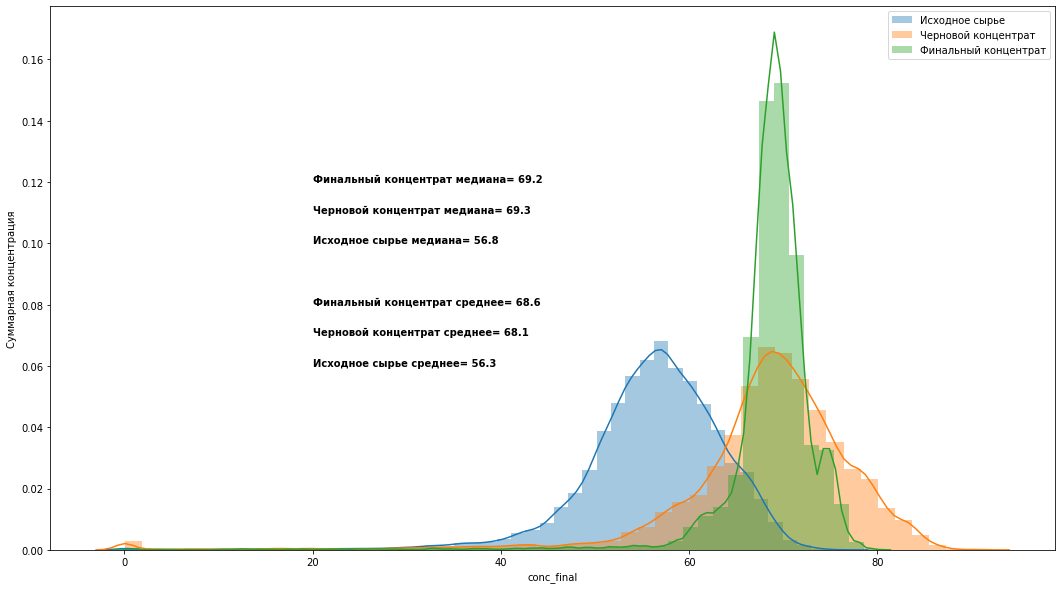

In [12]:
train['conc_rough_out'] = train['rougher.output.concentrate_ag']+train['rougher.output.concentrate_pb'] \
+ train['rougher.output.concentrate_sol']+train['rougher.output.concentrate_au']

train['conc_rough_in'] = train['rougher.input.feed_ag']+train['rougher.input.feed_pb'] \
+train['rougher.input.feed_sol']+train['rougher.input.feed_au']

train['conc_final']=train['final.output.concentrate_ag']+train['final.output.concentrate_pb'] \
+train['final.output.concentrate_sol']+train['final.output.concentrate_au']

legend=['Исходное сырье', 'Черновой концентрат','Финальный концентрат']
fig, ax = plt.subplots(figsize=(18, 10))
i=0
for data in [train['conc_rough_in'],train['conc_rough_out'],train['conc_final']]:
    sns.distplot(data, kde=True, ax=ax)
    plt.legend(legend)
    
    median = data.median()
    mean = data.mean()
    
    ax.set_ylabel('Суммарная концентрация')
    ax.text(20, 0.1+i*0.01 , legend[i]+' медиана= {:.1f} '.format(median),
            weight='semibold')
    ax.text(20, 0.06+i*0.01 , legend[i]+' среднее= {:.1f} '.format(mean),
            weight='semibold')
    i+=1
#print(legend[0])

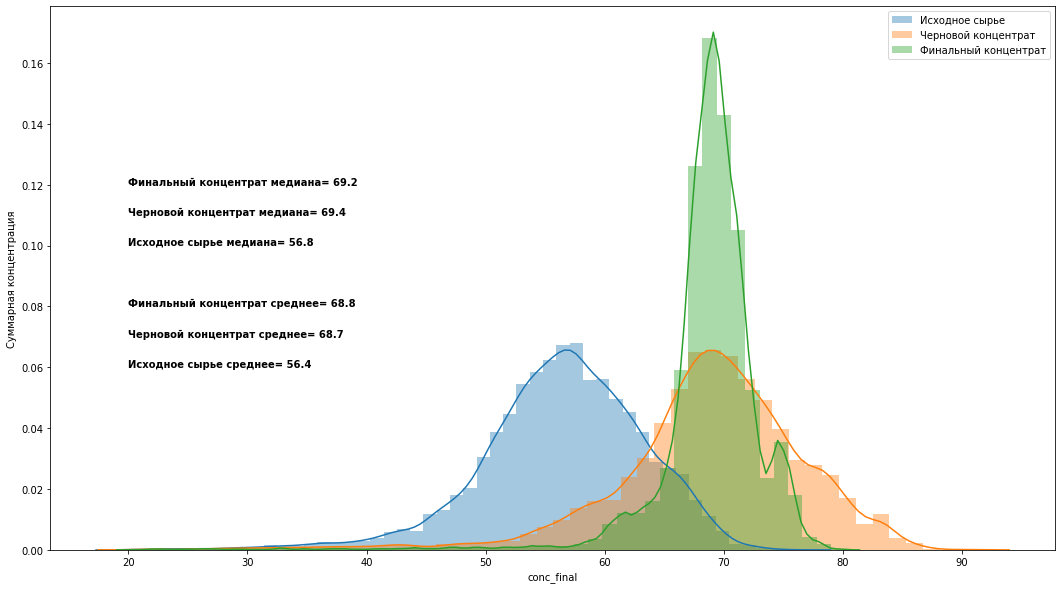

In [13]:
train = train.query('conc_rough_out>20 & conc_rough_in>20 & conc_final>20')
fig, ax = plt.subplots(figsize=(18, 10))
i=0
for data in [train['conc_rough_in'],train['conc_rough_out'],train['conc_final']]:
    sns.distplot(data, kde=True, ax=ax)
    plt.legend(legend)
    
    median = data.median()
    mean = data.mean()
    
    ax.set_ylabel('Суммарная концентрация')
    ax.text(20, 0.1+i*0.01 , legend[i]+' медиана= {:.1f} '.format(median),
            weight='semibold')
    ax.text(20, 0.06+i*0.01 , legend[i]+' среднее= {:.1f} '.format(mean),
            weight='semibold')
    i+=1
train = train.drop(['conc_rough_out','conc_rough_in','conc_final'], axis=1)

## Вывод
С каждым этапом очистки суммарная концентрация всех веществ увеличивается. 
Причем на этапе чернового концентрата увеличивается среднее значение, а на этапе финального концентрата увеличивается вероятность этого среднего значения.

<a id='part3'></a>
# 3. Модель
<a id='part3.1'></a>
## 3.1 Функция для подсчета итоговой sMAPE

In [14]:
def final_smape(valid,predict):
    
    smape=[0,0]
    
    for i in range(len(valid)):
        for j in (0,1):
            
            smape[j]+=2 * 100 * np.abs(valid.iloc[i][j]-predict[i][j]) / (np.abs(valid.iloc[i][j])+np.abs(predict[i][j]))
    smape = [i/len(predict) for i in smape]
    return smape[0]*0.25+smape[1]*0.75

# создаем метрику
final_smape_error = make_scorer(final_smape, greater_is_better=False)

<a id='part3.2'></a>
## 3.2 Разбиение данных

In [15]:
#train = train.drop(['conc_rough_out','conc_rough_in','conc_final'], axis=1)

train_features = train.drop(['date','rougher.output.recovery','final.output.recovery'], axis=1)
train_target = train[['rougher.output.recovery','final.output.recovery']]

test_features = test.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
test_target = test[['rougher.output.recovery','final.output.recovery']]

<a id='part3.3'></a>
## 3.3 Решающее дерево

In [16]:
## Тасуем данные, т.к. иначе большой разброс внутри массива результатов кросс-валидации 

cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=1)

depth =   [i for i in range(10,25)]
leafs =   [i for i in range(1,10)]
features = ['auto', 'sqrt', 'log2']

grid_search = GridSearchCV(
        estimator=DecisionTreeRegressor(random_state=1),
        param_grid={
            'max_depth': depth,
            'min_samples_leaf': leafs,
            'max_features' : features,
        },
        scoring=final_smape_error,
        cv = cv, n_jobs=-1)
    
grid_search_result = grid_search.fit(train_features, train_target)
best_params = grid_search_result.best_params_
print('Лучшие параметры модели:')
print(best_params)
print('Итоговая sMAPE: {:.2f} %'.format(grid_search_result.best_score_))


KeyboardInterrupt: 

<a id='part3.4'></a>
## 3.4 Случайный лес

In [ ]:
#estim  = [i for i in range(60,100,20)]
#depth  = [i for i in range(20,25)]
#samples= [i for i in range(2,5)]
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=1)
estim  = [i for i in range(80,100,20)]
depth  = [i for i in range(24,25)]
samples= [i for i in range(3,4)]


grid_search = GridSearchCV(
        estimator=RandomForestRegressor(random_state=1),
        param_grid={
            'max_depth': depth,
            'n_estimators': estim,
            'min_samples_split': samples,
        },
        scoring=final_smape_error,
        cv = cv, n_jobs=-1)
    
grid_search_result = grid_search.fit(train_features, train_target)
best_params = grid_search_result.best_params_
print('Лучшие параметры модели:')
print(best_params)
print('Итоговая sMAPE: {:.2f} %'.format(grid_search_result.best_score_))

<a id='part3.5'></a>
## 3.5 Линейная регрессия

In [ ]:
model = LinearRegression()

grid_search = GridSearchCV(
    estimator=LinearRegression(),
    param_grid={
        'fit_intercept':[True,False],
        'normalize':[True,False], 
        'copy_X':[True, False]
        },
        scoring=final_smape_error,
        cv = cv, n_jobs=-1)

grid_search_result = grid_search.fit(train_features, train_target)
best_params = grid_search_result.best_params_
print('Лучшие параметры модели:')
print(best_params)
print('Итоговая sMAPE: {:.2f} %'.format(grid_search_result.best_score_))

<a id='part3.6'></a>
## 3.6 Проверка на тестовой выборке

In [ ]:
model = RandomForestRegressor(random_state=1, max_depth=24, min_samples_split=3, n_estimators=80)

model.fit(train_features,train_target)
test_predictions = model.predict(test_features)
print('Итоговая sMAPE на тестовой выборке: {:.2f} %'.format(final_smape(test_target,test_predictions)))

In [ ]:
test_predictions = pd.DataFrame(test_predictions, columns=['rougher.output.recovery','final.output.recovery'])
print('Предсказанная медиана эффективности обогащения чернового концентрата:', 
      test_predictions['rougher.output.recovery'].median())
print('Реальная медиана эффективности обогащения чернового концентрата:', 
      test_target['rougher.output.recovery'].median(),'\n')
print('Предсказанная медиана эффективности обогащения финального концентрата:', 
      test_predictions['final.output.recovery'].median())
print('Реальная медиана эффективности обогащения финального концентрата:',
      test_target['final.output.recovery'].median())
 

## Вывод

Лучшей моделью по метрике sMAPE оказалась модель случайного леса с гиперпараметрами
'max_depth': 24, 'min_samples_split': 3, 'n_estimators': 80.

Итоговая sMAPE на тренировочных данных = 1.61%
Итоговая sMAPE на тестовых данных = 7.15%

Медианы целевых признаков для реальных и предсказанных данных на тестовой выборке практически равны.

<a id='part4'></a>
# Общий вывод

В результате работы были изучены и предобработаны сырые данные золотодобычи.  
Заполнены пропуски, удалены выбросы.

Был проведен анализ данных.  
Изучены изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки. 
Сравнены распределения размеров гранул сырья на обучающей и тестовой выборках.
Исследована суммарная концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.  

Методами кросс-валидации и поиска гиперпараметров по сетке было изучено три модели (дерево решений, случайный лес, логистическая регрессия).  
Лучшая модель была выбрана по метрике sMAPE (Symmetric Mean Absolute Percentage Error).  
Ею оказалась модель случайного леса с гиперпараметрами 'max_depth': 24, 'min_samples_split': 3, 'n_estimators': 80.
Качество модели было проверено на тестовой выборке.